In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
train_method = 'valid'

In [3]:
import pandas  as pd
from cdcp.paths import DATA_DIR, ensure_dir
import numpy as np
import matplotlib.pyplot as plt
import datetime
from pathlib2 import Path
from tqdm import tqdm
pd.set_option('display.max_columns', 500)
from functools import reduce
import scipy.stats

In [4]:
from cdcp.paths import DATA_PATH_MAGPI, FIGURE_DIR, ensure_dir
from cdcp.general import save_fig
SAVE_FIGS = True

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/general.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [5]:
from cdcp.visualization.colors import colors as cdcp_colors

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
from cdcp.paths import DATA_PATH_MAGPI, FIGURE_DIR, ensure_dir
from cdcp.general import save_fig

In [8]:
statistics_timestamp = '2021-10-23_23-02-31_846685'# datetime.now().strftime("%Y-%m-%d_%H-%M-%S_%f")#
statistics_timestamp

'2021-10-23_23-02-31_846685'

In [9]:
birds = [
    ('B1597', '2021-05-14_12-40-20_423998', 'kilosort2_5'),
    ('B1188', '2021-05-31_18-52-29_558216', 'kilosort2_5'),
    ('B1595', '2021-07-10_16-42-47_090257', 'kilosort2'),
    ('B1276', '2021-07-14_11-14-02_257025', 'kilosort2'),
    ('B1426', '2021-07-14_11-29-39_657273', 'kilosort2'),
    ('B1432', '2021-06-01_15-14-38_561892', 'kilosort2_5'),
    ('B1170', '2021-06-01_21-01-26_519005', 'kilosort2_5'),
    ('B1244', '2021-07-14_12-57-45_546674', 'kilosort2'),
    ('B1593', '2021-06-28_18-13-24_826008', 'kilosort2_5'),
    ('B1248', '2021-07-03_18-08-01_063431', 'kilosort2_5'),
    # acute
    #('B1279', '2021-04-12_16-27-07_289527', 'kilosort2_5'),
    #('B1500', '2021-08-27_09-24-48_680961', 'kilosort2_5'),
    #('B1239', '2021-05-17_22-18-51_557635', 'kilosort2'),
    #('B1459', '2021-08-26_21-21-12_755614', 'kilosort2_5'),
]
birds_df = pd.DataFrame(birds, columns = ['bird', 'timestamp', 'sorter']).set_index('bird')

In [10]:
identifiers = ['spike_count', 'unit_location', 'decoder_correctness']

In [12]:
all_unit_statistics_df= []
for bird, timestamp, sorter in tqdm(birds, desc='birds'):
    
    unit_statistics_df_list = []
    for identifier in identifiers:
        unit_statistics_df = pd.read_pickle(
        DATA_DIR
        / "unit_statistics"
        / statistics_timestamp
        / identifier
        / "{}.pickle".format(bird)
    )
        unit_statistics_df_list.append(unit_statistics_df)
        
    print(bird, 'nrows per', [len(i) for i in unit_statistics_df_list])
    
    # combine dfs
    unit_statistics_df = reduce(lambda x, y: pd.merge(x, y, on = 'unit', how='outer'), unit_statistics_df_list)
    unit_statistics_df['bird'] = bird
    
    all_unit_statistics_df.append(unit_statistics_df)

unit_statistics_df = pd.concat(all_unit_statistics_df)

birds:  30%|███       | 3/10 [00:00<00:00, 13.30it/s]

B1597 nrows per [6750, 8711, 6750]
B1188 nrows per [510, 821, 510]
B1595 nrows per [242, 325, 242]


birds:  60%|██████    | 6/10 [00:00<00:00, 16.29it/s]

B1276 nrows per [46, 57, 46]
B1426 nrows per [93, 180, 93]
B1432 nrows per [2157, 2364, 2157]
B1170 nrows per [1281, 1693, 1281]


birds:  80%|████████  | 8/10 [00:00<00:00, 16.01it/s]

B1244 nrows per [141, 150, 141]
B1593 nrows per [7714, 13260, 7714]


birds: 100%|██████████| 10/10 [00:00<00:00, 10.57it/s]

B1248 nrows per [8698, 13184, 8698]


In [13]:
# merge with categorical units
categorical_units_df = pd.read_pickle(DATA_DIR / 'categorical_unit_01_23_22.pickle')
categorical_units_df= categorical_units_df[categorical_units_df.categorical_unit == True]
unit_statistics_df_cat = pd.merge(unit_statistics_df, categorical_units_df, on = ['bird', 'unit'])
# subset categorical units
#unit_statistics_df_cat = unit_statistics_df_cat[unit_statistics_df_cat.categorical_unit == True]
unit_statistics_df = unit_statistics_df_cat
print(len(unit_statistics_df))

### merge with unit types
unit_type_df = pd.read_pickle(DATA_DIR / "unit_classes_01_23_22.pickle")
#unit_type_df = unit_type_df[["nuclei","AP","ML","DV","amplitude","template_amplitude","sr","fw","hw","bird","unit"]]
unit_statistics_df_ut = pd.merge(unit_statistics_df, unit_type_df, on = ['bird', 'unit'])
unit_statistics_df = unit_statistics_df_ut
print(len(unit_statistics_df))

6754
6754


In [14]:
unit_statistics_df = unit_statistics_df.sort_values(by=['n_active_trials'], ascending=False)

In [15]:
unit_statistics_df[:2]

,n_trials,n_cued_trials,n_incorrect_trials,n_correct_trials,n_reward_trials,n_passive_trials,n_active_trials,n_spikes,unit,hemisphere,labeled_region,estimated_nuclei,distance_to_estimated_nuclei,ML,AP,DV,AE_mean_correct,AE_mean_incorrect,AE_correct_t,AE_correct_p,AF_mean_correct,AF_mean_incorrect,AF_correct_t,AF_correct_p,BF_mean_correct,BF_mean_incorrect,BF_correct_t,BF_correct_p,BE_mean_correct,BE_mean_incorrect,BE_correct_t,BE_correct_p,BG_mean_correct,BG_mean_incorrect,BG_correct_t,BG_correct_p,CE_mean_correct,CE_mean_incorrect,CE_correct_t,CE_correct_p,CG_mean_correct,CG_mean_incorrect,CG_correct_t,CG_correct_p,AG_mean_correct,AG_mean_incorrect,AG_correct_t,AG_correct_p,CF_mean_correct,CF_mean_incorrect,CF_correct_t,CF_correct_p,bird,categorical_unit,categoricality,fw,sr,unit_type,best_chan_templates,best_chan_templates_norm,amplitude
1185,135308,22462,2952,21969,7852,108288,27020,3782468,3428,NaN,NaN,NCL,494.54,2731.25,2420.0,-802.499502,0.343833,0.32,0.71855,0.472486,0.283934,0.227941,1.947703,0.051562,0.31675,0.330396,-0.420082,0.674463,0.195622,0.157143,1.703268,0.08864,0.198992,0.144444,1.192916,0.233485,0.152709,0.131313,0.535872,0.592284,0.225962,0.170732,1.10831,0.268265,0.248815,0.326316,-1.550623,0.121606,0.288416,0.15625,2.223578,0.026637,B1597,True,0.499018,43.0,25.960996,1,"[14.0, 13.911411411411411, 13.822822822822824,...","[0.01709673880257429, 0.0169885548054323, 0.01...",-560.25
188,62396,16809,1337,17917,5211,42386,20010,1519167,11670,NaN,NaN,Field_L,558.515,2317.25,2420.0,-722.499502,0.259982,0.271186,-0.270191,0.787037,0.219341,0.221591,-0.069458,0.944631,0.242928,0.186992,1.414023,0.157488,0.166742,0.168627,-0.07646,0.939059,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B1597,True,0.433930,85.0,15.855983,0,"[46.5, 46.588588588588586, 46.67717717717718, ...","[0.08471652194211443, 0.08487791800897435, 0.0...",-447.00


In [16]:
unit_statistics_df["bird_unit"] = ["_".join([row.bird, row.unit]) for idx, row in unit_statistics_df.iterrows()]

### Set rows to stims

In [17]:
interps = ['AE', 'AF', 'AG', 'BE', 'BF', 'BG',  'CE', 'CF', 'CG'] #['AE', 'AF', 'BE', 'BF']

In [33]:
acc_df_interp = pd.DataFrame(
    #index = np.arange(len(unit_statistics_df)*len(interps)),
    columns = ['interp', 'unit', 'bird', 'mean_incorrect', 'mean_correct', 'correct_t', 'correct_p'] 
)
i = 0
n_skip = 0
for axi, (idx, row) in tqdm(enumerate(unit_statistics_df.iterrows()), total = len(unit_statistics_df)):
    for interp in interps:    
        
        if np.isnan(row[f'{interp}_mean_correct']):
            continue
        if np.isnan(row[f'{interp}_mean_incorrect']):
            continue
        
        if np.mean(row[f'{interp}_mean_correct']) < 1/16:
            continue
            
        #acc_df_interp.loc[i] = (
        acc_df_interp.loc[len(acc_df_interp)] = (
            [
                interp,
                row.bird_unit,
                row.bird,
                row[f'{interp}_mean_incorrect'],
                row[f'{interp}_mean_correct'],
                row[f'{interp}_correct_t'],
                row[f'{interp}_correct_p'],
                
                
                   ]
                
        )
        i+=1

100%|██████████| 6754/6754 [00:32<00:00, 206.92it/s] 


In [34]:
# only include interpolations where there are at least 1 sample for each cue / interp point
prop_units = len(np.unique(acc_df_interp.unit)) / len(unit_statistics_df)
print(f"prop units where sufficient data is available {prop_units}")

prop units where sufficient data is available 0.7016582765768433


In [35]:
acc_df_interp[:3]

,interp,unit,bird,mean_incorrect,mean_correct,correct_t,correct_p
0,AE,B1597_3428,B1597,0.320000,0.343833,0.718550,0.472486
1,AF,B1597_3428,B1597,0.227941,0.283934,1.947703,0.051562
2,AG,B1597_3428,B1597,0.326316,0.248815,-1.550623,0.121606


In [59]:
correctness_diff = acc_df_interp.mean_correct.values  - acc_df_interp.mean_incorrect.values
acc_df_interp['correctness_diff'] = correctness_diff

In [60]:
np.mean(correctness_diff), np.median(correctness_diff)

(0.0029784385135286163, 0.012598425196850394)

In [66]:
mean_diff_by_unit = acc_df_interp[['unit', 'correctness_diff']].groupby(by="unit").mean()

In [67]:
mean_diff_by_unit

,correctness_diff
unit,
B1170_1002,-0.008004
B1170_1027,0.003943
B1170_1037,0.000220
B1170_1038,0.010374
B1170_1044,-0.007136
...,...
B1597_9830,0.026322
B1597_9918,0.015613
B1597_9962,0.015992


In [68]:
np.mean(mean_diff_by_unit.correctness_diff > 0)

0.5722726313568264

In [71]:
scipy.stats.ttest_1samp(mean_diff_by_unit.correctness_diff, 0)

TtestResult(statistic=4.894890054033204, pvalue=1.0162744081047937e-06, df=4738)

In [70]:
scipy.stats.binomtest(
    np.sum(mean_diff_by_unit.correctness_diff > 0), n=len(mean_diff_by_unit), p=0.5
)

BinomTestResult(k=2712, n=4739, alternative='two-sided', statistic=0.5722726313568264, pvalue=2.441272324328651e-23)

In [63]:
np.mean(acc_df_interp.mean_correct.values  > acc_df_interp.mean_incorrect.values)

0.5595727702412375

(-0.25, 0.25)

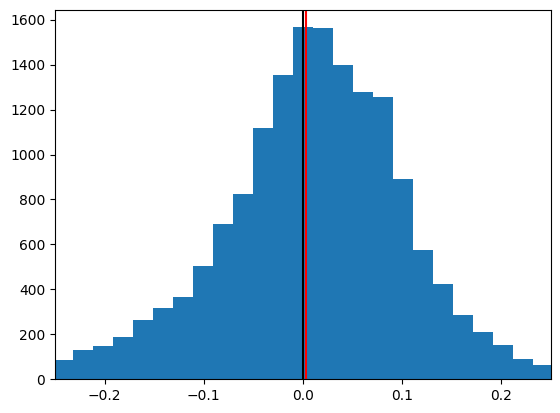

In [62]:
fig, ax = plt.subplots()
ax.hist(correctness_diff, bins=np.linspace(-1,1,100));
ax.axvline(np.mean(correctness_diff), color = 'red')
ax.axvline(0, color = 'k')
ax.set_xlim([-0.25,0.25])